# PROYECTO PARCIAL DE ANALISIS EXPLORATORIO DE DATOS

## Importaciones 

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carga de DataSets

En esta parte cargamos los datasets y añadimos las columnas extras necesarias:
  - vistas --> rp_vistas_c.csv
  - sitios --> ma_sitios2.csv  --> Añadir columna de ubicacion basada en su latitud y longitud

## Dataframe Vistas
Registros de personas que intentaron conectarse a un sitio y se arrepintieron o tuvieron que intentarlo más de una vez

**Observación:** Este dataframe es muchísimo más grande que el de Conexiones, debido a que se nos proporcionó registros adicionales de un período más extenso de tiempo; el mismo período de tiempo adicional no se pudo recuperar para la tabla conexiones.


In [83]:
vistas = pd.read_csv('rp_vistas_c.csv',sep=';',index_col=False, parse_dates={'datetime':['fecha','hora']}, usecols=["codigo","pauta_id","sitio_id","mac_usr","fecha","hora","so","navegador"])
vistas.head(3)

,datetime,codigo,pauta_id,sitio_id,mac_usr,so,navegador
0,2015-05-15 20:15:09,1,20,3,74:AA:FE:A5:7E:90,ANDROID,CXHROME
1,2015-05-15 20:15:28,3,18,3,74:AA:FE:A5:7E:90,ANDROID,CHROME
2,2015-05-15 20:15:31,4,20,3,B4:52:7E:3F:CF:B4,ANDROID,CHROME


Se necesita parsear la columna datatime al formato correcto, y separaremos los valores en varias columnas

In [84]:
vistas["mes"] = vistas["datetime"].dt.month
vistas["anio"] = vistas["datetime"].dt.year
vistas["hora"] = vistas["datetime"].dt.hour
vistas["fecha"] = vistas["datetime"].dt.date
vistas["weekday"] = vistas["datetime"].dt.weekday
vistas.head(2)

,datetime,codigo,pauta_id,sitio_id,mac_usr,so,navegador,mes,anio,hora,fecha,weekday
0,2015-05-15 20:15:09,1,20,3,74:AA:FE:A5:7E:90,ANDROID,CXHROME,5,2015,20,2015-05-15,4
1,2015-05-15 20:15:28,3,18,3,74:AA:FE:A5:7E:90,ANDROID,CHROME,5,2015,20,2015-05-15,4


Analizaremos algunos de los valores para ver que tenemos, en este caso, so, navegador y fabricante-dispositivo, seran objeto del analisis.

In [85]:
# eliminar las macs que no son validas

validacionMAC = "^(([0-9A-Fa-f]{2}:){5})([0-9A-Fa-f]{2})$"

vistas["filtroMAC"] = vistas['mac_usr'].str.contains(validacionMAC)
# data = data[filter]

# print(data)

vistas = vistas[vistas["filtroMAC"] == True]

# print(nuevoData)

del vistas["filtroMAC"]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



## SO 

### en Vistas

In [44]:
vistas["so"].value_counts()

ANDROID       1161556
IPHONE         441895
OTROS           82385
WINDOWS7        43362
IPAD            18015
WINDOWS8        11129
MAC              9454
NOKIA            7901
WINDOWS10        6917
WINDOWS          5203
WINDOWSXP        4213
BLACKBERRY       2891
WINPHONE         1540
LINUX             943
WINDOWSV          253
WINDOWSS            6
Name: so, dtype: int64

Podemos observar que existen valores que podemos englobar en uno solo, para un mejor analisis.

### Categorizar SO 

In [5]:
def clasificadorSO(so):
    try:
        if so.lower().startswith("windows"):
            return "WINDOWS"
        if so.lower().startswith("android"):
            return "ANDROID"
        if so.lower() == "ipad" or so.lower() == "iphone" or so.lower() == "ios" or so.lower() == "mac" or so.lower() == "mac os x":
            return "iOS"
        if so.lower().startswith("linux"):
            return "LINUX"
        if so.lower() == "otros":
            return "Other"
        return so
    except:
        return "Other"

In [125]:
vistas["so"]  = vistas["so"].apply(lambda x: clasificadorSO(x))
vistas["so"].value_counts()

ANDROID       1161488
iOS            469122
Other           82280
WINDOWS         70871
NOKIA            7900
BLACKBERRY       2891
WINPHONE         1540
LINUX             943
Name: so, dtype: int64

# Navegador 

In [94]:
vistas["navegador"].value_counts()

CHROME        833075
OTROS         482845
SAFARI        437091
IE             25211
FIREFOX        17624
BLACKBERRY      1698
OPERA             64
MOZILLA           54
CXHROME            1
Name: navegador, dtype: int64

Podemos observar que Other y Otros se refieren a lo mismo por lo tanto no deberia existir distincion.

### Categorizar Navegador

In [7]:
def clasificadorNavegador(navegador):
    try:
        if str(navegador.lower()) == "otros" or str(navegador.lower()) == "opera":
            return "OTHER"
        if navegador.lower() == "cxhrome":
            return "CHROME"
        if str(navegador.lower()) == "mozilla" or str(navegador.lower()) == "firefox":
            return "FIREFOX"
        return navegador
    except:
        return "OTHER"

In [126]:
vistas["navegador"] = vistas["navegador"].apply(lambda x: clasificadorNavegador(x))
vistas["navegador"].value_counts()

CHROME        832812
OTHER         482904
SAFARI        436740
IE             25210
FIREFOX        17671
BLACKBERRY      1698
Name: navegador, dtype: int64

## Sitios 

In [86]:
# sitios = pd.DataFrame.from_csv("ma_sitios2.csv", sep = ",").reset_index()
sitios = pd.read_csv('ma_sitios.csv', sep=',', index_col=False, usecols=["sitio_id","nombre","ciudad","longitud","latitud"])
sitios.head(3)

,sitio_id,nombre,ciudad,longitud,latitud
0,1,ALBAN BORJA,Guayaquil,-2.168677,-79.916769
1,2,VILLAGE PLAZA,Guayaquil,-2.140406,-79.866376
2,3,CITY MALL,Guayaquil,-2.140951,-79.911774


Como vemos contamos con latitud y longitud, para este analisis agregaremos una nueva columna llamada localizacion, en donde nos dara el lugar geografico donde se encuentra.

## expectativa de personas mensuales en centros comerciales

In [87]:
expectativa_cc = pd.DataFrame({"CentroComercial":["CentroConvenciones", "CityMall", "Aeropuerto", "MallSur", "Samborondon"], "poblacion_mensual":[55000,1200000,600000,1300000,750000]})
expectativa_cc

,CentroComercial,poblacion_mensual
0,CentroConvenciones,55000
1,CityMall,1200000
2,Aeropuerto,600000
3,MallSur,1300000
4,Samborondon,750000


## Localizar Sitios 

Necesitaremos el boundingbox de los lugares el cual lo llamaremos places

In [88]:
places =[["Urdesa", [[-79.915581,-2.178119], [-79.901204,-2.146938]]],
             ["MallSur", [[-79.902062,-2.232042], [-79.894681,-2.226038]]],
             ["CityMall", [[-79.912663,-2.143936], [-79.905968,-2.137932]]],
             ["AlbanBorja", [[-79.918242,-2.170096], [-79.915066,-2.167523]]],
             ["Samborondon", [[-79.874897,-2.160447], [-79.852066,-2.116704]]],
             ["Aeropuerto", [[-79.886227,-2.152728], [-79.880562,-2.146338]]],
             ["Penias", [[-79.8776014239,-2.1855487464], [-79.873009,-2.175392]]],
             ["Quito", [[-78.586922,-0.395161], [-78.274155,0.021973]]],
             ["CentroConvenciones", [[-79.893479,-2.161755], [-79.883652,-2.154894]]],
             ["HiltonColon", [[-79.8998951912,-2.160929558], [-79.8962903023,-2.1576274229]]],
             ["MallSol", [[-79.8954641819,-2.157053837], [-79.8891341686,-2.1539258197]]],
             ["UniversidadGuayaquil", [[-79.9008607864,-2.1847947751], [-79.8959684372,-2.1791554991]]]
            ]

Funcion para localizar las coordenadas

In [89]:
def localizar(row, places):
    longitud = float(row["longitud"])
    latitud = float(row["latitud"])

    for placeName, ubicacion in places:
        SW, NE= ubicacion
        if (latitud <= NE[0] and longitud <=NE[1] and latitud >= SW[0] and longitud >= SW[1]):
            return placeName
    return "No ubicado"

In [90]:
sitios['localizacion'] = sitios[["longitud", "latitud"]].apply(lambda row: localizar(row, places), axis = 1)
# sitios.to_csv("ma_sitios_filtered.csv")
# sitios[sitios["localizacion"].isin(["CentroConvenciones", "CityMall", "Aeropuerto", "MallSur", "Samborondon"])]["localizacion"].value_counts()


## aps por sitio

In [91]:
aps_cc = pd.DataFrame({"CentroComercial":["CentroConvenciones", "CityMall", "Aeropuerto", "MallSur", "Samborondon"], "#aps":[33,8,20,6,11]})
aps_cc

,#aps,CentroComercial
0,33,CentroConvenciones
1,8,CityMall
2,20,Aeropuerto
3,6,MallSur
4,11,Samborondon


# UNIENDO LOS DATAFRAMES

In [92]:
data_completa = pd.merge(vistas, sitios, on='sitio_id')
data_completa.head(3)

,datetime,codigo,pauta_id,sitio_id,mac_usr,so,navegador,mes,anio,hora,fecha,weekday,nombre,ciudad,longitud,latitud,localizacion
0,2015-05-15 20:15:09,1,20,3,74:AA:FE:A5:7E:90,ANDROID,CXHROME,5,2015,20,2015-05-15,4,CITY MALL,Guayaquil,-2.140951,-79.911774,CityMall
1,2015-05-15 20:15:28,3,18,3,74:AA:FE:A5:7E:90,ANDROID,CHROME,5,2015,20,2015-05-15,4,CITY MALL,Guayaquil,-2.140951,-79.911774,CityMall
2,2015-05-15 20:15:31,4,20,3,B4:52:7E:3F:CF:B4,ANDROID,CHROME,5,2015,20,2015-05-15,4,CITY MALL,Guayaquil,-2.140951,-79.911774,CityMall


# ANALISIS #1.- Cantidad de Usuarios conectados por hora en un día

Necesitaremos la franja_horaria, la fecha, localizacion, mac_usr

In [65]:
data_completaAnalisis1 = data_completa.copy()[["fecha", "hora", "localizacion", "mac_usr"]]
data_completaAnalisis1_Agrup = data_completaAnalisis1.groupby(["fecha", "hora", "localizacion"]).size().rename("cant_conexiones")
Analisis1_sin_aeropuerto = data_completaAnalisis1[data_completaAnalisis1['localizacion'] != "Aeropuerto"].copy()
Analisis1_sin_aeropuerto_Agrup = Analisis1_sin_aeropuerto.groupby(["fecha", "hora", "localizacion"]).size().rename("cant_conexiones")
data_completaAnalisis1_Agrup

fecha       hora  localizacion        
2015-05-15  20    AlbanBorja               24
                  CityMall                113
                  Samborondon              45
            21    AlbanBorja                5
                  CityMall                 99
                  Samborondon              76
            22    CityMall                 40
                  Quito                     3
                  Samborondon              14
            23    CityMall                 18
                  Quito                     9
                  Samborondon               7
2015-05-16  0     Quito                     5
                  Samborondon               4
            2     Quito                     7
            3     Quito                     9
            4     Quito                     1
            8     Samborondon               6
            9     AlbanBorja                3
                  Samborondon               3
            10    AlbanBorja             

## Analisis general sin diferenciar la localizacion 

In [23]:
data_completaAnalisis1_1_2 = data_completaAnalisis1_Agrup.reset_index()
data_completaAnalisis1_1_2 = data_completaAnalisis1_1.groupby(["fecha", "hora"]).sum()
data_completaAnalisis1_1_2

cant_conexiones
fecha      hora                 
2015-05-15 20                182
           21                180
           22                 57
           23                 34
2015-05-16 0                   9
           2                   7
           3                   9
           4                   1
           8                   6
           9                   6
           10                 20
           11                101
           12                 79
           13                253
           14                278
           15                381
           16                276
           17                261
           18                251
           19                189
           20                266
           21                225
           22                121
           23                 77
2015-05-17 0                  83
           1                  35
           2                  22
           3                  15
           4                   5
           7                   1
...                          ...
2016-08-26 11                499
           12                547
           13                644
           14                551
           15                541
           16                683
           17                650
           18                454
           19                292
           20                272
           21                162
           22                 46
           23                 96
2016-08-27 0                  97
           1                 127
           2                  82
           3                  79
           4                 181
           5                 284
           6                 247
           7                 219
           8                 338
           9                 329
           10                311
           11                366
           12                592
           13                661
           14                698
           15                578
           16                247

[10663 rows x 1 columns]

Sacando promedio de conexiones entre dias para cada franja horaria

In [61]:
dataAnalisis1_1 = data_completaAnalisis1_Agrup.reset_index().copy()
dataAnalisis1_1 = dataAnalisis1_1.groupby(["hora"]).mean().add_prefix("mean_")
data_alternative_1_1 = Analisis1_sin_aeropuerto_Agrup.reset_index().copy()
data_alternative_1_1 = data_alternative_1_1.groupby(["hora"]).mean().add_prefix("mean_")
dataAnalisis1_1

,mean_cant_conexiones
hora,
0,21.378341
1,18.310174
2,14.529924
3,18.329870
4,24.839204
5,38.858108
6,31.788190
7,28.471530
8,27.417526


### GRAFICO: cantidad de conexiones promedio por horas

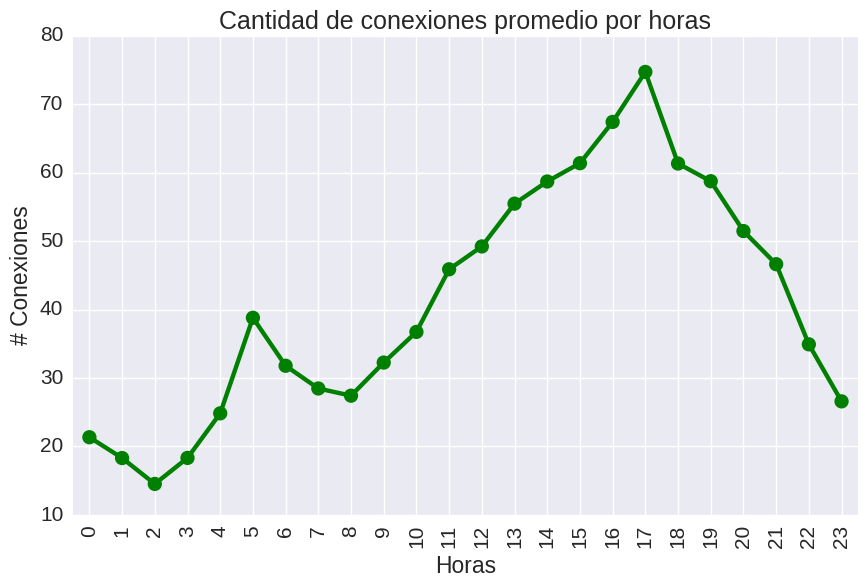

In [66]:
sns.set(font_scale=1.5)
g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=dataAnalisis1_1.reset_index(), color = "Green", size=6, aspect=1.5)
plt.xticks(rotation=90)
plt.xlabel("Horas")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio por horas") 
plt.show()

## mismo grafico sin datos de aeropuerto

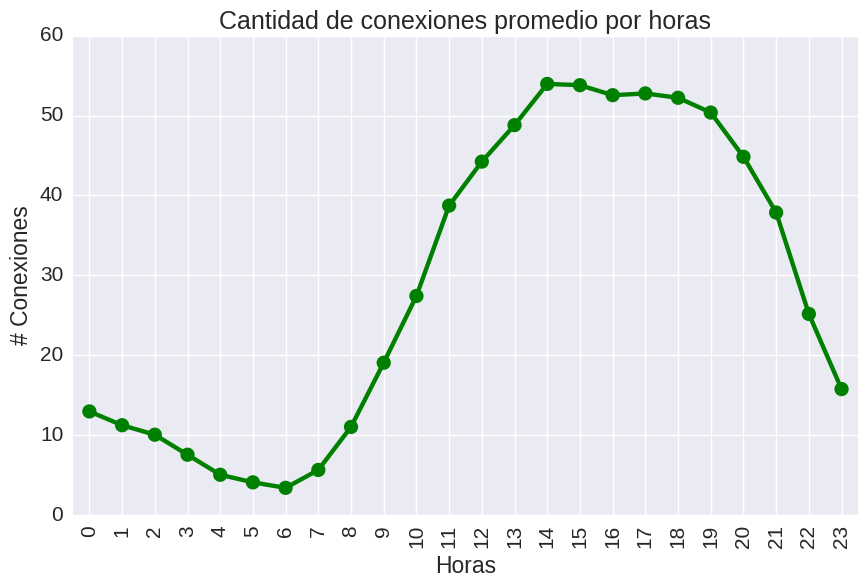

In [62]:
sns.set(font_scale=1.5)
g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_alternative_1_1.reset_index(), color = "Green", size=6, aspect=1.5)
plt.xticks(rotation=90)
plt.xlabel("Horas")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio por horas") 
plt.show()

## Analisis en base de la localizacion

In [66]:
def sacarMes(fecha):
    aux = str(fecha).split("-")
    return "-".join(aux[:2])

In [67]:
dataLocalizacion =data_completaAnalisis1_Agrup.reset_index().copy()


dataLocalizacion["mes"] = dataLocalizacion["fecha"].apply(lambda x: sacarMes(x))
# agrupamos por mes apra sacar las cantidades por mes por localizacion
dataLocalizacion = dataLocalizacion[["fecha", "cant_conexiones", "mes", "localizacion"]].groupby(["mes", "localizacion"]).sum().reset_index()
#ahora, sacamos la media por mes, por localizacion
dataLocalizacion= dataLocalizacion.groupby("localizacion").mean().add_prefix("mean_")
# ordenamos el dataset en base a las conexiones promedio por mes
dataLocalizacion = dataLocalizacion.reset_index().sort_values("mean_cant_conexiones", ascending = False).reset_index()
dataLocalizacion

,index,localizacion,mean_cant_conexiones
0,0,Aeropuerto,101076.200000
1,6,MallSur,39976.666667
2,3,CityMall,38820.166667
3,2,CentroConvenciones,29262.500000
4,9,Samborondon,12797.692308
5,11,Urdesa,6993.181818
6,1,AlbanBorja,3796.812500
7,5,MallSol,3378.750000
8,10,UniversidadGuayaquil,1841.000000
9,7,Penias,1835.428571


## Graficando

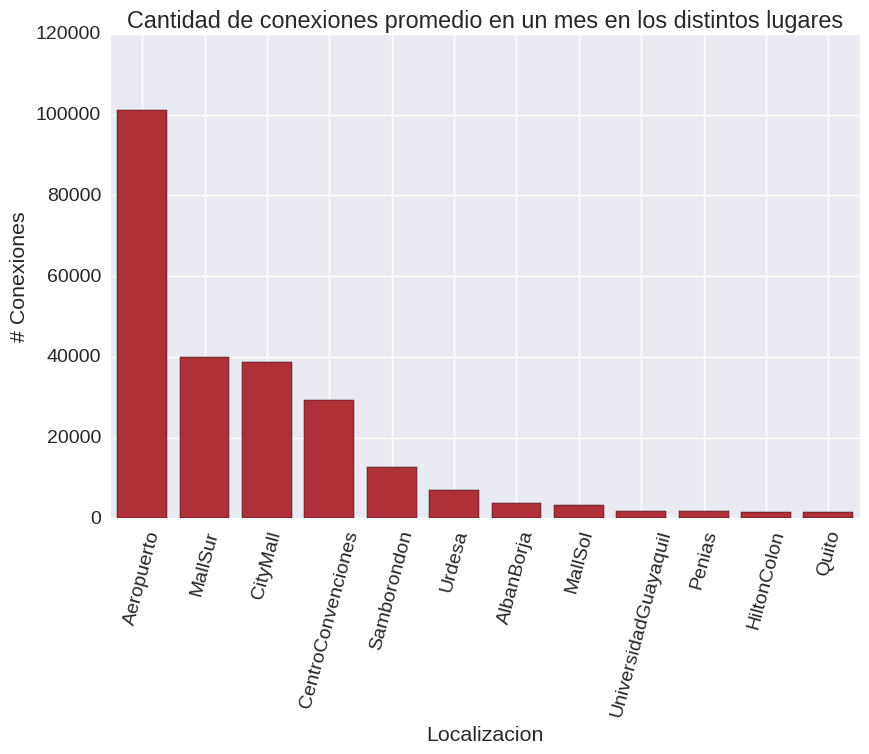

In [39]:
sns.set(font_scale=1.4)
cm = plt.cm.get_cmap('RdYlBu_r')
g = sns.factorplot(x="localizacion", y="mean_cant_conexiones", data=dataLocalizacion, color = cm(240), size=6, aspect=1.5, kind = "bar")
plt.xticks(rotation=75)
plt.xlabel("Localizacion")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio en un mes en los distintos lugares") 
plt.show()

### Agrupando lugares de pocas conexiones al mes 

Existen muchas localizaciones, se ha decidio mantener el top#5 y agregar una nueva categoria llamada OTHER a el resto de lugares.

In [68]:
top5 = dataLocalizacion[0:5].set_index("localizacion").to_dict("index")
top5

{'Aeropuerto': {'index': 0.0, 'mean_cant_conexiones': 101076.2},
 'CentroConvenciones': {'index': 2.0, 'mean_cant_conexiones': 29262.5},
 'CityMall': {'index': 3.0, 'mean_cant_conexiones': 38820.166666666664},
 'MallSur': {'index': 6.0, 'mean_cant_conexiones': 39976.666666666664},
 'Samborondon': {'index': 9.0, 'mean_cant_conexiones': 12797.692307692309}}

In [69]:
def FiltrarLugares(top5, lugar):
    if lugar not in top5:
        return "OTHER"
    return lugar

In [70]:
dataLocalizacionFiltrada= dataLocalizacion.copy()
dataLocalizacionFiltrada["localizacion_filtrada"] = dataLocalizacionFiltrada["localizacion"].apply(lambda x: FiltrarLugares(top5, x))
dataLocalizacionFiltrada = dataLocalizacionFiltrada.groupby("localizacion_filtrada").sum().reset_index()
dataLocalizacionFiltrada = dataLocalizacionFiltrada.sort_values("mean_cant_conexiones", ascending = False).reset_index()
dataLocalizacionFiltrada

,level_0,localizacion_filtrada,index,mean_cant_conexiones
0,0,Aeropuerto,0,101076.200000
1,3,MallSur,6,39976.666667
2,2,CityMall,3,38820.166667
3,1,CentroConvenciones,2,29262.500000
4,4,OTHER,46,21230.797890
5,5,Samborondon,9,12797.692308


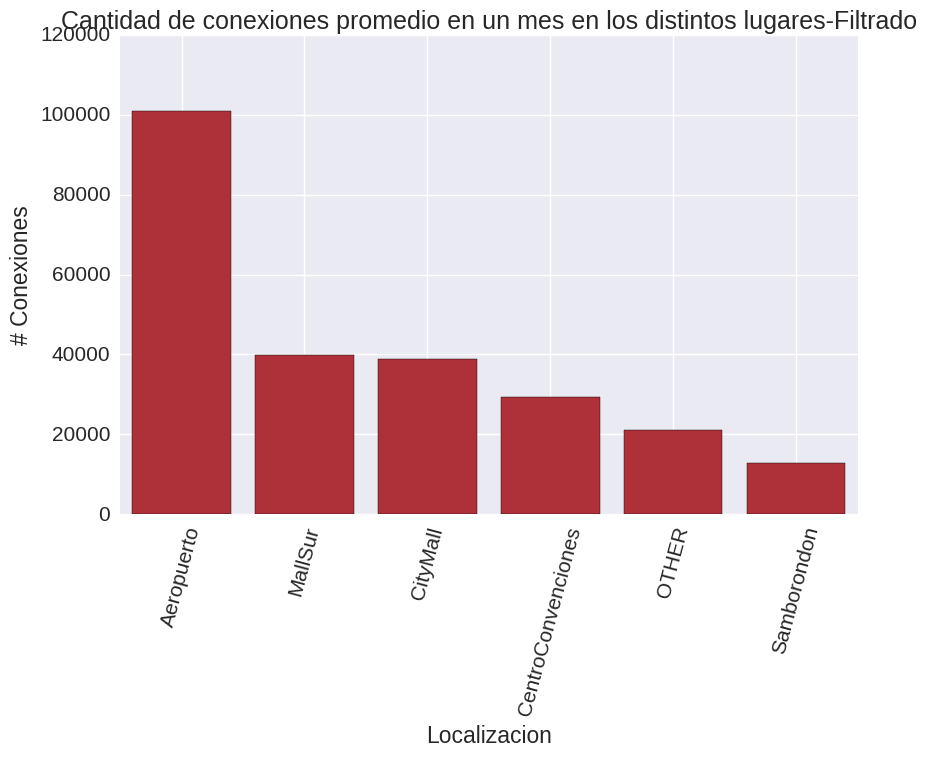

In [59]:
cm = plt.cm.get_cmap('RdYlBu_r')
g = sns.factorplot(x="localizacion_filtrada", y="mean_cant_conexiones", data=dataLocalizacionFiltrada, color = cm(240), size=6, aspect=1.5, kind = "bar")
plt.xticks(rotation=75)
plt.xlabel("Localizacion")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio en un mes en los distintos lugares-Filtrado") 
plt.show()

## Analisis especifico diferenciando por localizaciones 

In [60]:
dataAnalisis1_2 = data_completaAnalisis1.copy()
dataAnalisis1_2["localizacion_filtrada"] = dataAnalisis1_2["localizacion"].apply(lambda x: FiltrarLugares(top5, x))
dataAnalisis1_2 = dataAnalisis1_2.groupby(["localizacion_filtrada", "fecha", "hora"]).size().rename("cant_conexiones").reset_index()
dataAnalisis1_2 = dataAnalisis1_2.groupby(["localizacion_filtrada", "hora"]).mean().add_prefix("mean_").reset_index()
dataAnalisis1_2

,localizacion_filtrada,hora,mean_cant_conexiones
0,Aeropuerto,0,117.957265
1,Aeropuerto,1,85.652174
2,Aeropuerto,2,45.895652
3,Aeropuerto,3,79.782609
4,Aeropuerto,4,117.504348
5,Aeropuerto,5,183.104348
6,Aeropuerto,6,195.730435
7,Aeropuerto,7,228.852174
8,Aeropuerto,8,232.286957
9,Aeropuerto,9,225.017241


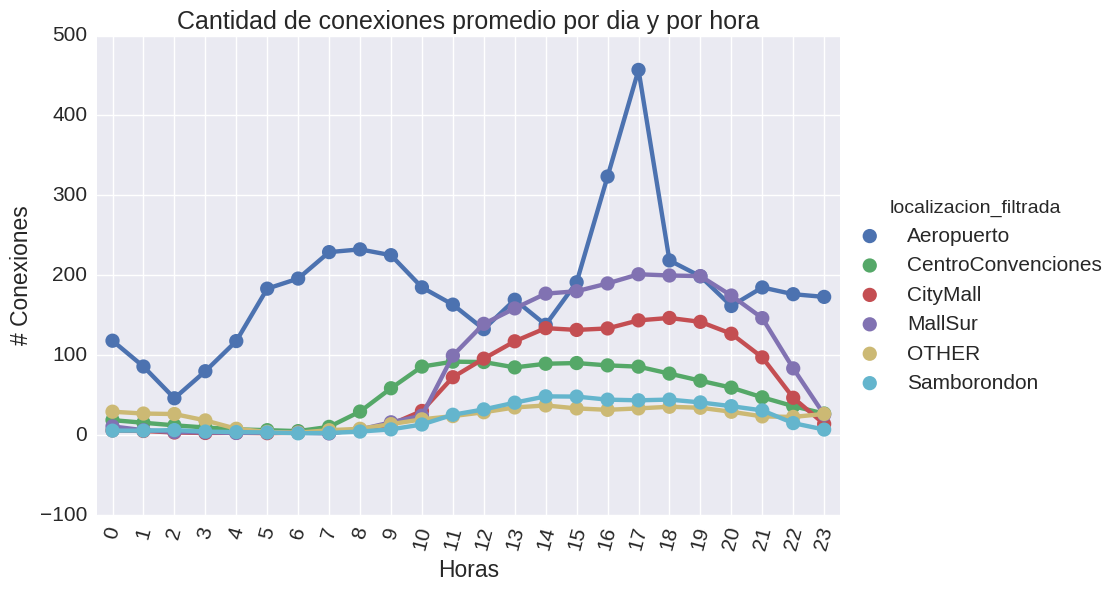

In [63]:
sns.set(font_scale=1.5)
g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=dataAnalisis1_2, size=6, aspect=1.5, hue = "localizacion_filtrada")
plt.xticks(rotation=75)
plt.xlabel("Horas")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio por dia y por hora") 
plt.show()

In [72]:
# veamos paso a paso que se está haciendo:
# dato1melt no distingue por localizacion
dato1melt = dataAnalisis1_1.reset_index().rename(columns={'hora': 'hora', 'mean_cant_conexiones': 'TODOS'})
#dato2melt distingue por localizacion, y se lo expande horizontalmente
dato2melt = dataAnalisis1_2.pivot(index='hora', columns='localizacion_filtrada', values='mean_cant_conexiones').reset_index()
# datamerged contiene la columna TODOS para cada hora
datamerged = pd.merge(dato1melt, dato2melt, on = "hora")
dataUnif = pd.melt(datamerged, id_vars=['hora'], var_name='localizacion_filtrada', value_name='mean_cant_conexiones')
dataUnif
# dato1melt.head()

,hora,localizacion_filtrada,mean_cant_conexiones
0,0,TODOS,21.351129
1,1,TODOS,18.311828
2,2,TODOS,14.529924
3,3,TODOS,18.331169
4,4,TODOS,24.839204
5,5,TODOS,38.794266
6,6,TODOS,31.788190
7,7,TODOS,28.471530
8,8,TODOS,27.418814
9,9,TODOS,32.253731


In [74]:
dataAnalisis2 = data_completa.copy()[["fecha", "localizacion", "mac_usr", "so", "navegador"]]
dataAnalisis2["mes"] = dataAnalisis2["fecha"].apply(lambda x: sacarMes(x))
dataAnalisis2["localizacion_filtrada"] = dataAnalisis2["localizacion"].apply(lambda x: FiltrarLugares(top5, x))

dataAnalisis2.head(2)

,fecha,localizacion,mac_usr,so,navegador,mes,localizacion_filtrada
0,2015-05-15,CityMall,74:AA:FE:A5:7E:90,ANDROID,CHROME,2015-05,CityMall
1,2015-05-15,CityMall,74:AA:FE:A5:7E:90,ANDROID,CHROME,2015-05,CityMall


## -SO

In [75]:
dataAnalisis2SO = dataAnalisis2.groupby(["mes","so"]).size().rename("cant_conexiones").reset_index()
dataAnalisis2SO = dataAnalisis2SO.groupby(["so"]).mean().add_prefix("mean_").reset_index()
dataAnalisis2SO = dataAnalisis2SO.sort_values("mean_cant_conexiones", ascending = False).reset_index()
dataAnalisis2SO

,index,so,mean_cant_conexiones
0,0,ANDROID,70500.312500
1,7,iOS,29087.250000
2,4,Other,5063.687500
3,5,WINDOWS,4380.875000
4,3,NOKIA,965.500000
5,6,WINPHONE,352.750000
6,1,BLACKBERRY,306.666667
7,2,LINUX,129.285714


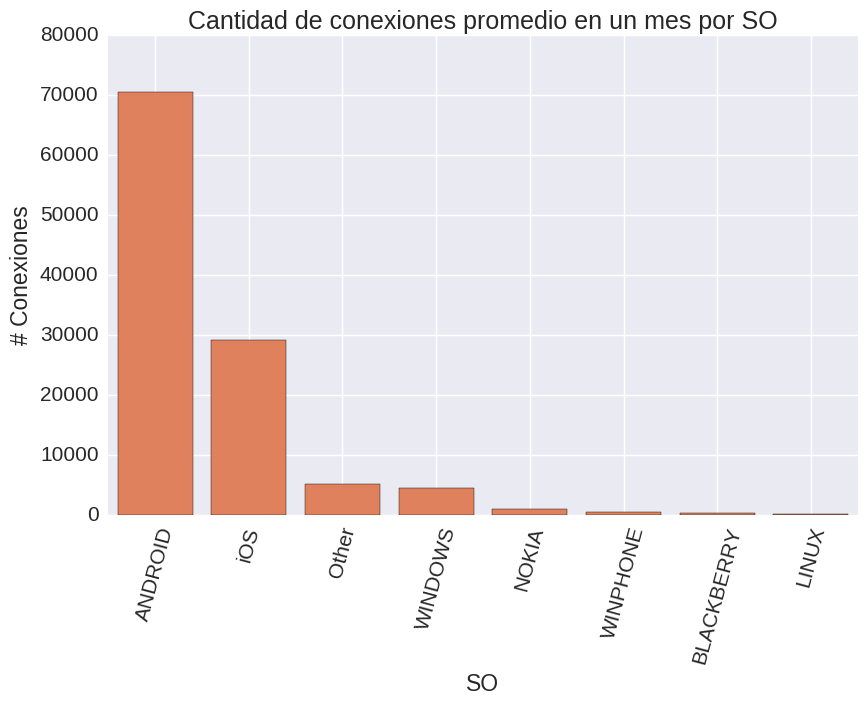

In [76]:
cm = plt.cm.get_cmap('RdYlBu_r')
g = sns.factorplot(x="so", y="mean_cant_conexiones", data=dataAnalisis2SO, color = cm(200), size=6, aspect=1.5, kind = "bar")
plt.xticks(rotation=75)
plt.xlabel("SO")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio en un mes por SO") 
plt.show()

In [77]:
dataAnalisis2SOLocalizacion = dataAnalisis2.groupby(["localizacion_filtrada","mes","so"]).size().rename("cant_conexiones").reset_index()
dataAnalisis2SOLocalizacion = dataAnalisis2SOLocalizacion.groupby(["localizacion_filtrada","so"]).mean().add_prefix("mean_").reset_index()
dataAnalisis2SOLocalizacion = dataAnalisis2SOLocalizacion.sort_values(["localizacion_filtrada","mean_cant_conexiones"], ascending = [True,False]).reset_index()
dataAnalisis2SOLocalizacion

,index,localizacion_filtrada,so,mean_cant_conexiones
0,0,Aeropuerto,ANDROID,51339.600000
1,6,Aeropuerto,iOS,44778.600000
2,5,Aeropuerto,WINDOWS,3574.200000
3,3,Aeropuerto,NOKIA,621.200000
4,4,Aeropuerto,Other,393.000000
5,1,Aeropuerto,BLACKBERRY,224.000000
6,2,Aeropuerto,LINUX,182.000000
7,7,CentroConvenciones,ANDROID,19033.357143
8,14,CentroConvenciones,iOS,7608.071429
9,12,CentroConvenciones,WINDOWS,1150.928571


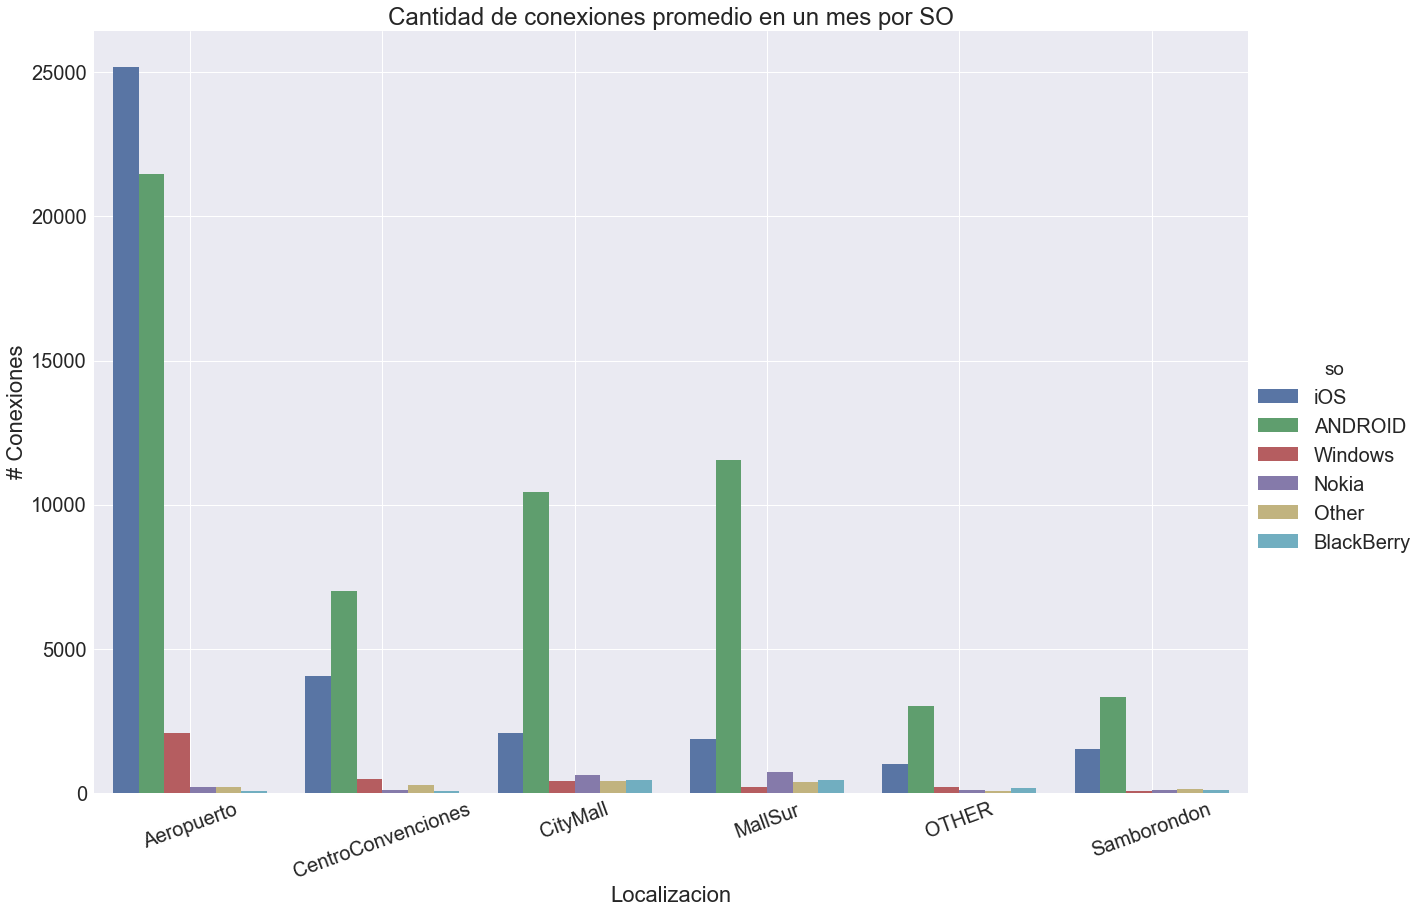

In [42]:
sns.set(font_scale=2)
cm = plt.cm.get_cmap('RdYlBu_r')
g = sns.factorplot(x="localizacion_filtrada", y="mean_cant_conexiones", data=dataAnalisis2SOLocalizacion, size=12, aspect=1.5, kind = "bar", hue = "so")
plt.xticks(rotation=20)
plt.xlabel("Localizacion")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio en un mes por SO") 
plt.show()

## -Navegador 

In [78]:
dataAnalisis2Nav = dataAnalisis2.groupby(["mes","navegador"]).size().rename("cant_conexiones").reset_index()
dataAnalisis2Nav = dataAnalisis2Nav.groupby(["navegador"]).mean().add_prefix("mean_").reset_index()
dataAnalisis2Nav = dataAnalisis2Nav.sort_values("mean_cant_conexiones", ascending = False).reset_index()
dataAnalisis2Nav

,index,navegador,mean_cant_conexiones
0,1,CHROME,50604.187500
1,4,OTHER,29898.875000
2,5,SAFARI,26606.125000
3,3,IE,1542.687500
4,2,FIREFOX,1076.062500
5,0,BLACKBERRY,277.833333


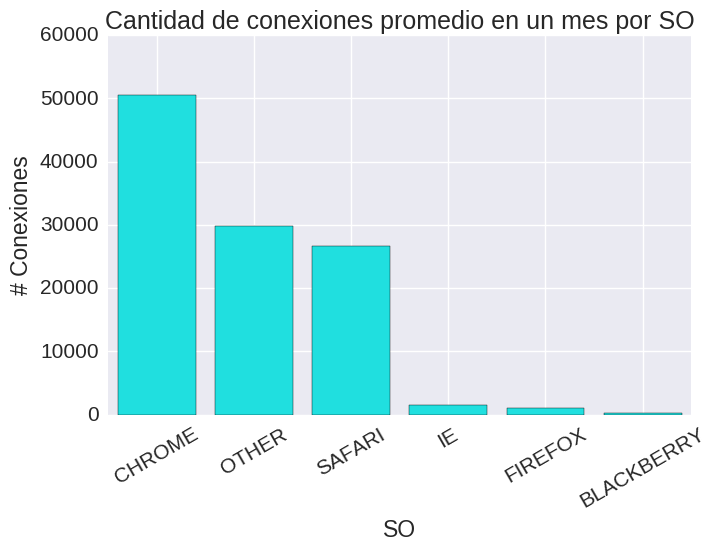

In [79]:
sns.set(font_scale=1.5)
cm = plt.cm.get_cmap('RdYlBu_r')
g = sns.factorplot(x="navegador", y="mean_cant_conexiones", data=dataAnalisis2Nav, color = "Cyan", size=5, aspect=1.5, kind = "bar")
plt.xticks(rotation=30)
plt.xlabel("SO")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio en un mes por Navegador") 
plt.show()

In [80]:
dataAnalisis2NavLocalizacion = dataAnalisis2.groupby(["localizacion_filtrada","mes","navegador"]).size().rename("cant_conexiones").reset_index()
dataAnalisis2NavLocalizacion = dataAnalisis2NavLocalizacion.groupby(["localizacion_filtrada","navegador"]).mean().add_prefix("mean_").reset_index()
dataAnalisis2NavLocalizacion = dataAnalisis2NavLocalizacion.sort_values(["localizacion_filtrada","mean_cant_conexiones"], ascending = [True,False]).reset_index()
dataAnalisis2NavLocalizacion

,index,localizacion_filtrada,navegador,mean_cant_conexiones
0,1,Aeropuerto,CHROME,46918.600000
1,4,Aeropuerto,OTHER,43051.800000
2,5,Aeropuerto,SAFARI,9505.000000
3,2,Aeropuerto,FIREFOX,847.200000
4,3,Aeropuerto,IE,693.800000
5,0,Aeropuerto,BLACKBERRY,149.500000
6,7,CentroConvenciones,CHROME,14580.785714
7,10,CentroConvenciones,OTHER,7494.428571
8,11,CentroConvenciones,SAFARI,6488.714286
9,9,CentroConvenciones,IE,361.785714


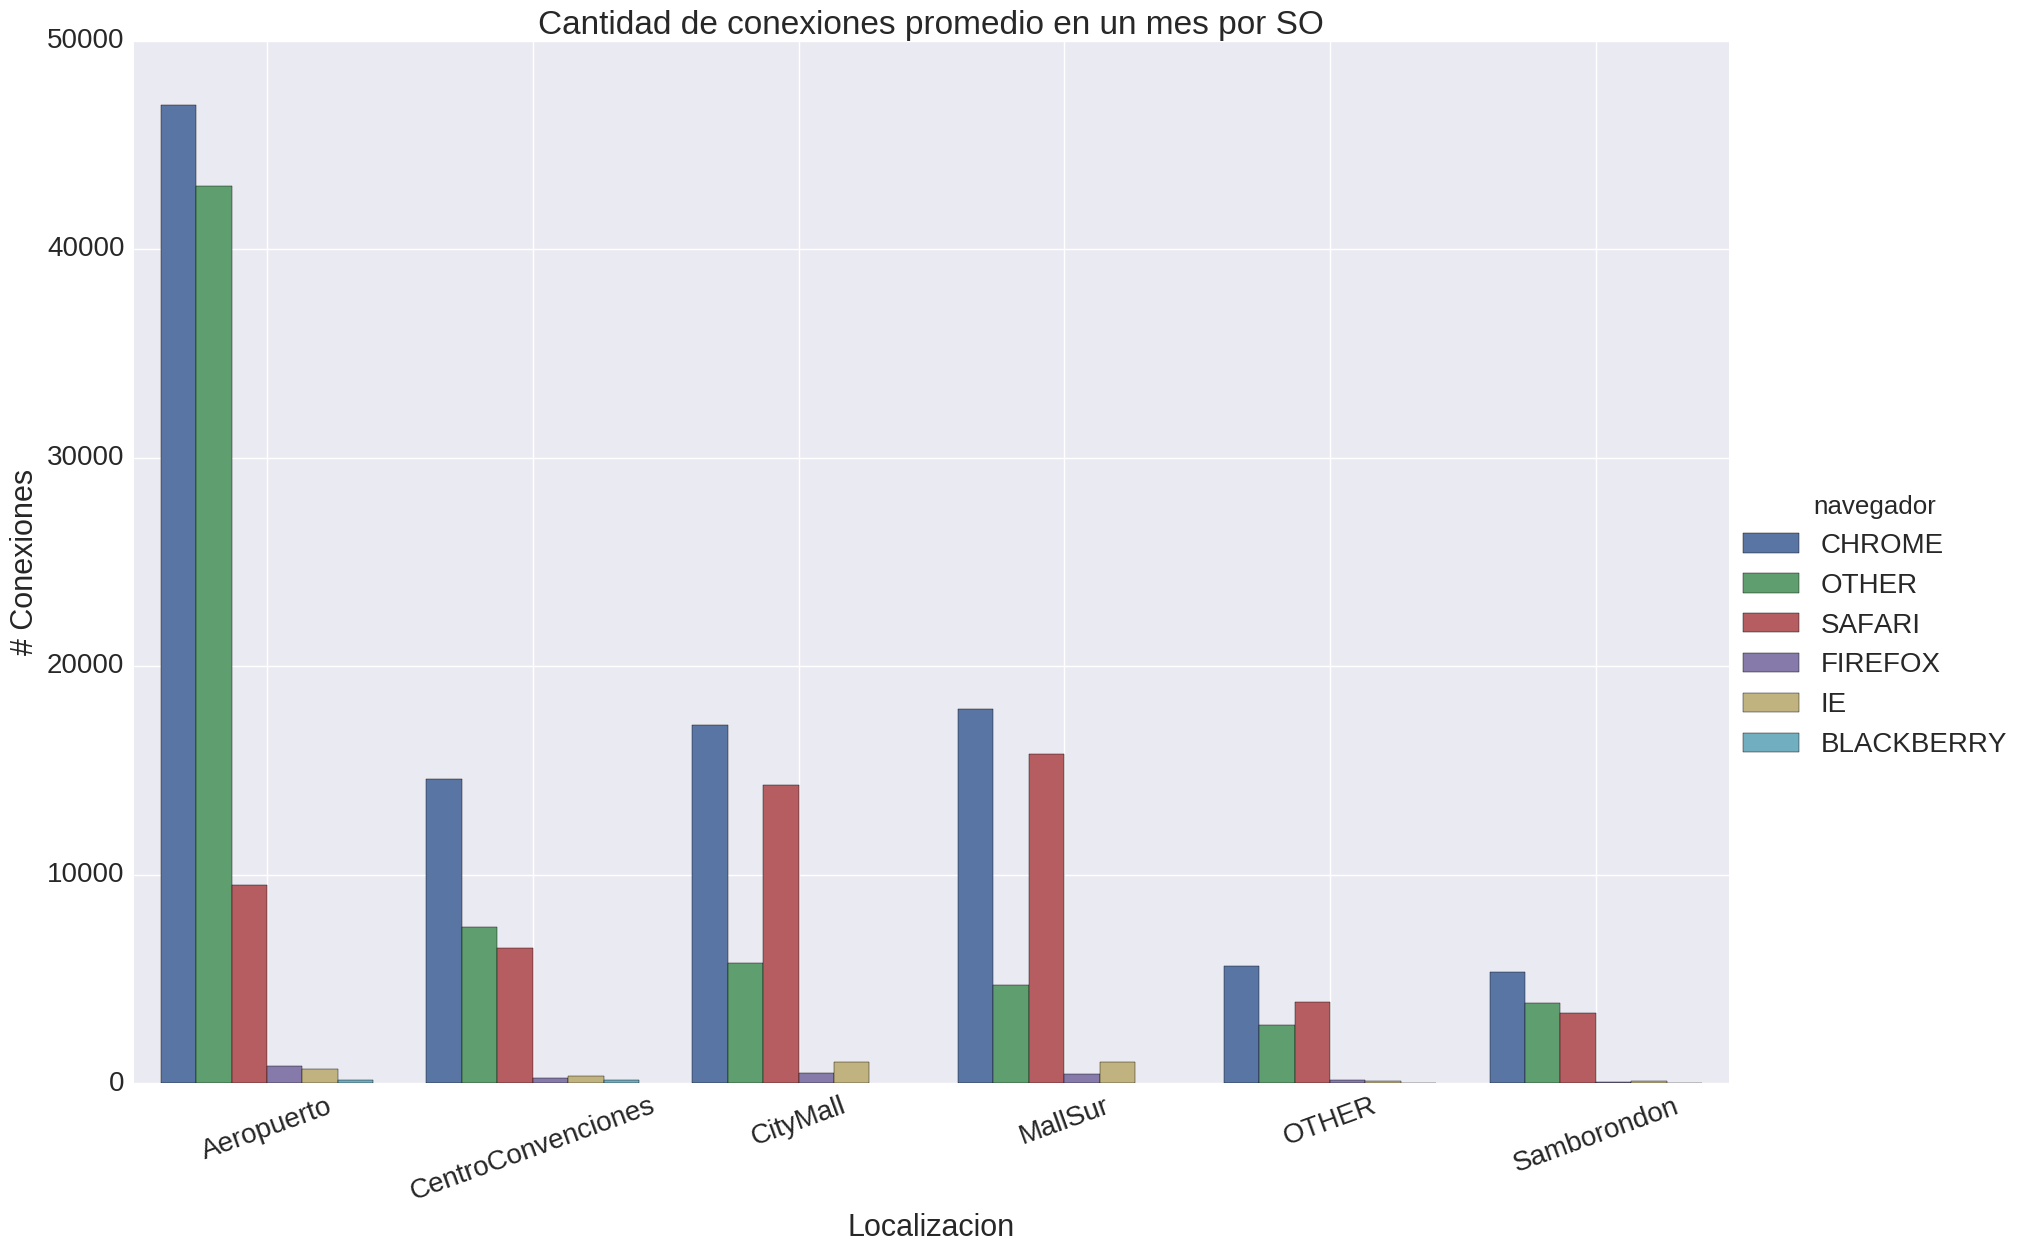

In [81]:
sns.set(font_scale=2)
cm = plt.cm.get_cmap('RdYlBu_r')
g = sns.factorplot(x="localizacion_filtrada", y="mean_cant_conexiones", data=dataAnalisis2NavLocalizacion, size=12, aspect=1.5, kind = "bar", hue = "navegador")
plt.xticks(rotation=20)
plt.xlabel("Localizacion")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio en un mes por Navegador") 
plt.show()

# Categorizando a los usuarios en base a que tanto frecuentan las localizaciones en un mes

In [20]:
dataAnalisis3 = data_completa.copy()[["fecha", "localizacion", "mac_usr"]]
dataAnalisis3["mes"] = dataAnalisis3["fecha"].apply(lambda x: sacarMes(x))
dataAnalisis3["localizacion_filtrada"] = dataAnalisis3["localizacion"].apply(lambda x: FiltrarLugares(top5, x))
dataAnalisis3.head(3)

,fecha,localizacion,mac_usr,mes,localizacion_filtrada
0,2015-05-15,CityMall,74:AA:FE:A5:7E:90,2015-05,CityMall
1,2015-05-15,CityMall,74:AA:FE:A5:7E:90,2015-05,CityMall
2,2015-05-15,CityMall,B4:52:7E:3F:CF:B4,2015-05,CityMall


In [21]:
dataAnalisis3 = dataAnalisis3.groupby(["mes", "localizacion_filtrada", "mac_usr"]).size().rename("cant_conexiones").reset_index()
dataAnalisis3 = dataAnalisis3.groupby(["mac_usr","localizacion_filtrada"]).mean().add_prefix("mean_").reset_index()
dataAnalisis3 =dataAnalisis3.sort_values("mean_cant_conexiones", ascending = False)
dataAnalisis3

,mac_usr,localizacion_filtrada,mean_cant_conexiones
194763,78:C3:E9:30:BB:44,CentroConvenciones,1864.000000
83273,2C:F0:EE:0F:64:C6,OTHER,981.000000
395928,FC:DB:B3:2B:99:40,CentroConvenciones,612.000000
169607,68:76:4F:69:65:8B,OTHER,558.400000
14874,00:73:E0:AD:73:07,OTHER,543.000000
354282,E4:98:D6:8B:02:A3,CentroConvenciones,489.000000
331460,D0:92:9E:0F:27:14,Aeropuerto,485.333333
273688,AC:B5:7D:66:DE:11,MallSur,380.000000
364616,EC:1F:72:5C:02:74,CentroConvenciones,373.000000
208457,84:2E:27:FF:31:F1,CityMall,358.000000


## Top 5 usuarios por lugar

In [24]:
dataAnalisis3_top_users = dataAnalisis3.sort_values(["localizacion_filtrada","mean_cant_conexiones"], ascending = [False,False])
# obteniendo top5 usuarios por localizacion
dataAnalisis3_top_users = dataAnalisis3_top_users.groupby(['localizacion_filtrada'], sort=False).head(5)

In [59]:
dataAnalisis3_top_users.to_csv("macs_tops_usuarios.csv")

In [25]:
lista_top_macs = dataAnalisis3_top_users.mac_usr.tolist()
len(lista_top_macs)

30

In [52]:
# horas de conexion de los top usuarios
data_top_usuarios = data_completa[data_completa['mac_usr'].isin(lista_top_macs)][['fecha','hora', 'weekday', 'localizacion','mac_usr', 'so', 'navegador']]
data_top_usuarios = data_top_usuarios.sort_values(["localizacion","hora", "mac_usr"], ascending=True)
# data_top_usuarios.mac_usr
data_top_usuarios.localizacion.value_counts()
data_top_usuarios2 = data_top_usuarios.copy()
data_top_usuarios_aeropuerto = data_top_usuarios2[data_top_usuarios2['localizacion']=="Aeropuerto"]
data_top_usuarios_centroconvenciones = data_top_usuarios2[data_top_usuarios2['localizacion']=="CentroConvenciones"]
data_top_usuarios_citymall = data_top_usuarios2[data_top_usuarios2['localizacion']=="CityMall"]
data_top_usuarios_mallsur = data_top_usuarios2[data_top_usuarios2['localizacion']=="MallSur"]
data_top_usuarios_samborondon = data_top_usuarios2[data_top_usuarios2['localizacion']=="Samborondon"]
data_top_usuarios_penias = data_top_usuarios2[data_top_usuarios2['localizacion']=="Penias"]
data_top_usuarios_urdesa = data_top_usuarios2[data_top_usuarios2['localizacion']=="Urdesa"]
data_top_usuarios_mallsol = data_top_usuarios2[data_top_usuarios2['localizacion']=="MallSol"]
# data_top_usuarios_albanborja = data_top_usuarios2[data_top_usuarios['localizacion']=="AlbanBorja"]

In [53]:
data_top_usuarios = data_top_usuarios.groupby(['mac_usr', 'fecha' ,'hora']).size().rename("cant_conexiones").reset_index()
data_top_usuarios_aeropuerto = data_top_usuarios_aeropuerto.groupby(['mac_usr', 'fecha' ,'hora']).size().rename("cant_conexiones").reset_index()
data_top_usuarios_centroconvenciones = data_top_usuarios_centroconvenciones.groupby(['mac_usr', 'fecha' ,'hora']).size().rename("cant_conexiones").reset_index()
data_top_usuarios_citymall = data_top_usuarios_citymall.groupby(['mac_usr', 'fecha' ,'hora']).size().rename("cant_conexiones").reset_index()
data_top_usuarios_mallsur = data_top_usuarios_mallsur.groupby(['mac_usr', 'fecha' ,'hora']).size().rename("cant_conexiones").reset_index()
data_top_usuarios_samborondon = data_top_usuarios_samborondon.groupby(['mac_usr', 'fecha' ,'hora']).size().rename("cant_conexiones").reset_index()
data_top_usuarios_penias = data_top_usuarios_penias.groupby(['mac_usr', 'fecha' ,'hora']).size().rename("cant_conexiones").reset_index()
data_top_usuarios_urdesa = data_top_usuarios_urdesa.groupby(['mac_usr', 'fecha' ,'hora']).size().rename("cant_conexiones").reset_index()
data_top_usuarios_mallsol = data_top_usuarios_mallsol.groupby(['mac_usr', 'fecha' ,'hora']).size().rename("cant_conexiones").reset_index()


In [54]:
data_top_usuarios = data_top_usuarios.groupby(["mac_usr", "hora"]).mean().add_prefix("mean_").reset_index()
data_top_usuarios_aeropuerto = data_top_usuarios_aeropuerto.groupby(["mac_usr", "hora"]).mean().add_prefix("mean_").reset_index()
data_top_usuarios_centroconvenciones = data_top_usuarios_centroconvenciones.groupby(["mac_usr", "hora"]).mean().add_prefix("mean_").reset_index()
data_top_usuarios_citymall = data_top_usuarios_citymall.groupby(["mac_usr", "hora"]).mean().add_prefix("mean_").reset_index()
data_top_usuarios_mallsur = data_top_usuarios_mallsur.groupby(["mac_usr", "hora"]).mean().add_prefix("mean_").reset_index()
data_top_usuarios_samborondon = data_top_usuarios_samborondon.groupby(["mac_usr", "hora"]).mean().add_prefix("mean_").reset_index()
data_top_usuarios_penias = data_top_usuarios_penias.groupby(["mac_usr", "hora"]).mean().add_prefix("mean_").reset_index()
data_top_usuarios_urdesa = data_top_usuarios_urdesa.groupby(["mac_usr", "hora"]).mean().add_prefix("mean_").reset_index()
data_top_usuarios_mallsol = data_top_usuarios_mallsol.groupby(["mac_usr", "hora"]).mean().add_prefix("mean_").reset_index()

## Cantidad de conexiones promedio de top usuarios por hora en el aeropuerto

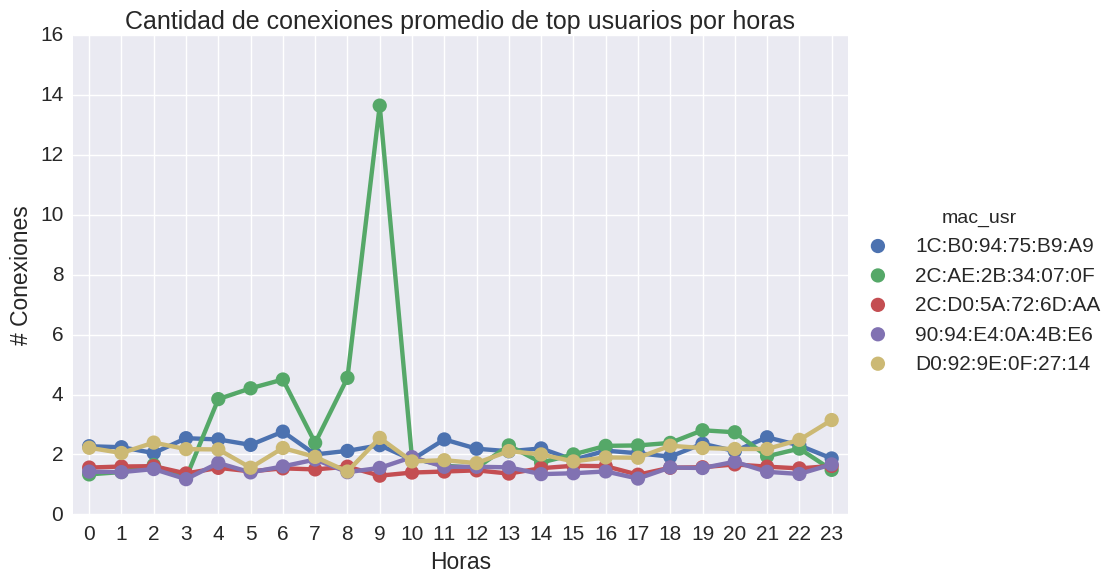

In [42]:
sns.set(font_scale=1.5)
# g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios, size=6, aspect=1.5, hue = "mac_usr")
g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios_aeropuerto, size=6, aspect=1.5, hue = "mac_usr")
plt.xticks(rotation=0)
plt.xlabel("Horas")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio de top usuarios por horas") 
plt.show()

## Cantidad de conexiones promedio de top usuarios por hora en centro de convenciones

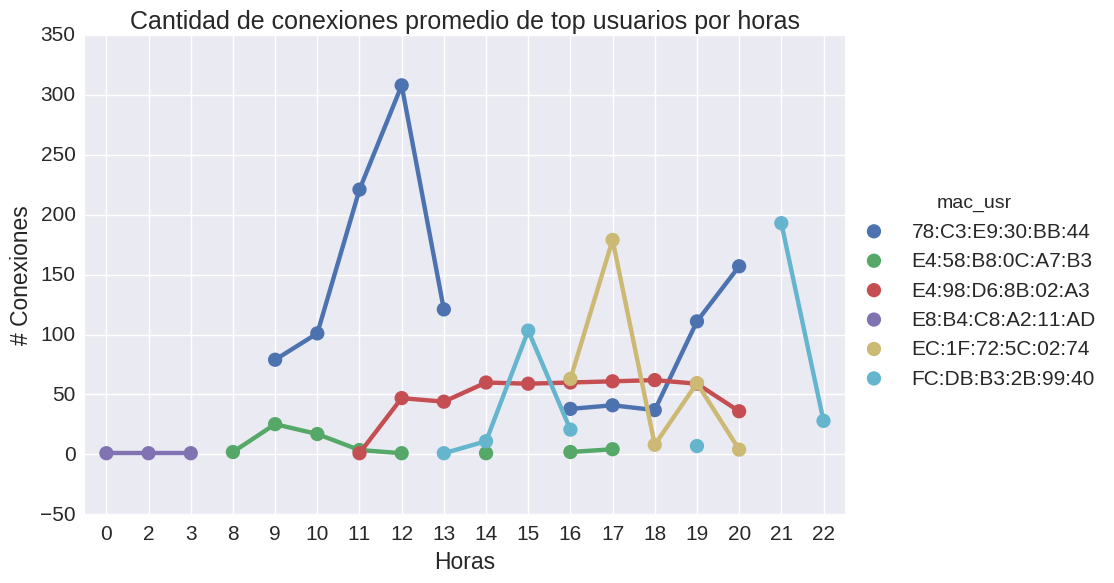

In [43]:
sns.set(font_scale=1.5)
# g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios, size=6, aspect=1.5, hue = "mac_usr")
g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios_centroconvenciones, size=6, aspect=1.5, hue = "mac_usr")
plt.xticks(rotation=0)
plt.xlabel("Horas")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio de top usuarios por horas") 
plt.show()

## Cantidad de conexiones promedio de top usuarios por hora en el CityMall

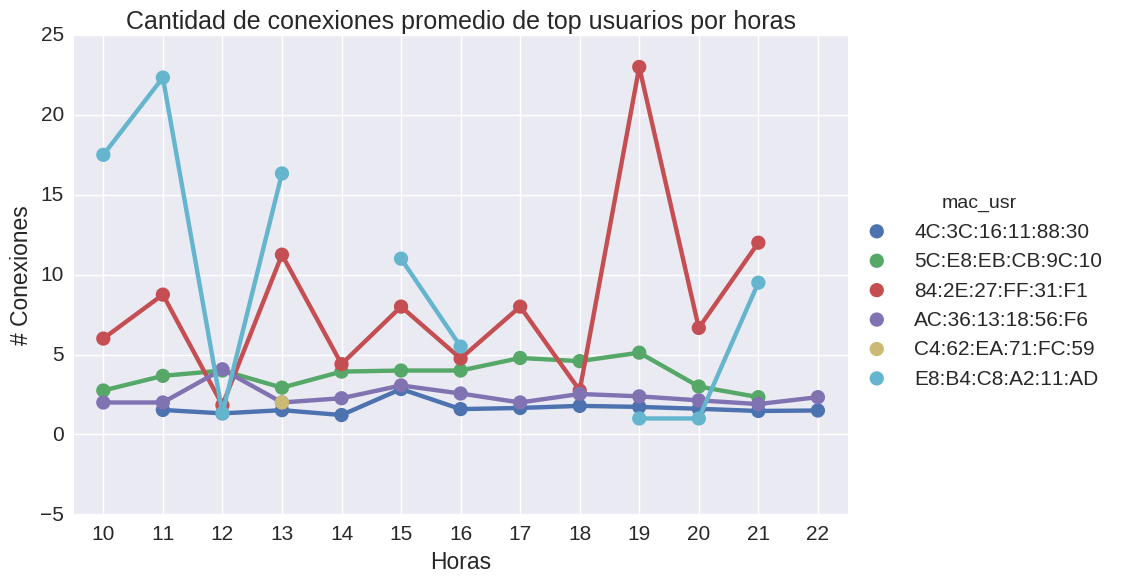

In [44]:
sns.set(font_scale=1.5)
# g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios, size=6, aspect=1.5, hue = "mac_usr")
g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios_citymall, size=6, aspect=1.5, hue = "mac_usr")
plt.xticks(rotation=0)
plt.xlabel("Horas")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio de top usuarios por horas") 
plt.show()

## Cantidad de conexiones promedio de top usuarios por hora en el Mall del Sur

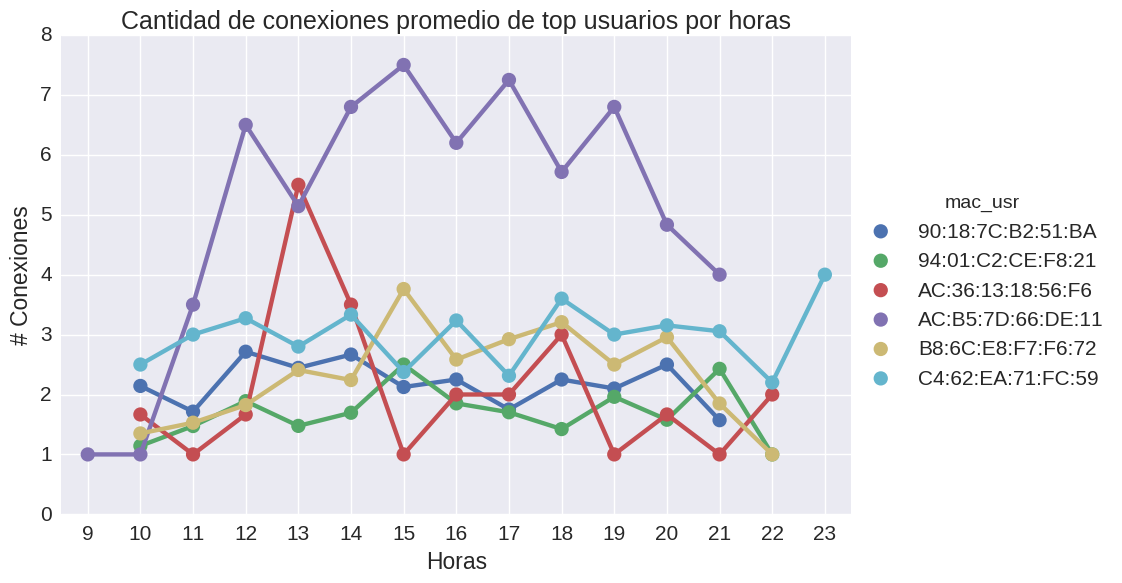

In [45]:
sns.set(font_scale=1.5)
# g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios, size=6, aspect=1.5, hue = "mac_usr")
g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios_mallsur, size=6, aspect=1.5, hue = "mac_usr")
plt.xticks(rotation=0)
plt.xlabel("Horas")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio de top usuarios por horas") 
plt.show()

## Cantidad de conexiones promedio de top usuarios por hora en Samborondon

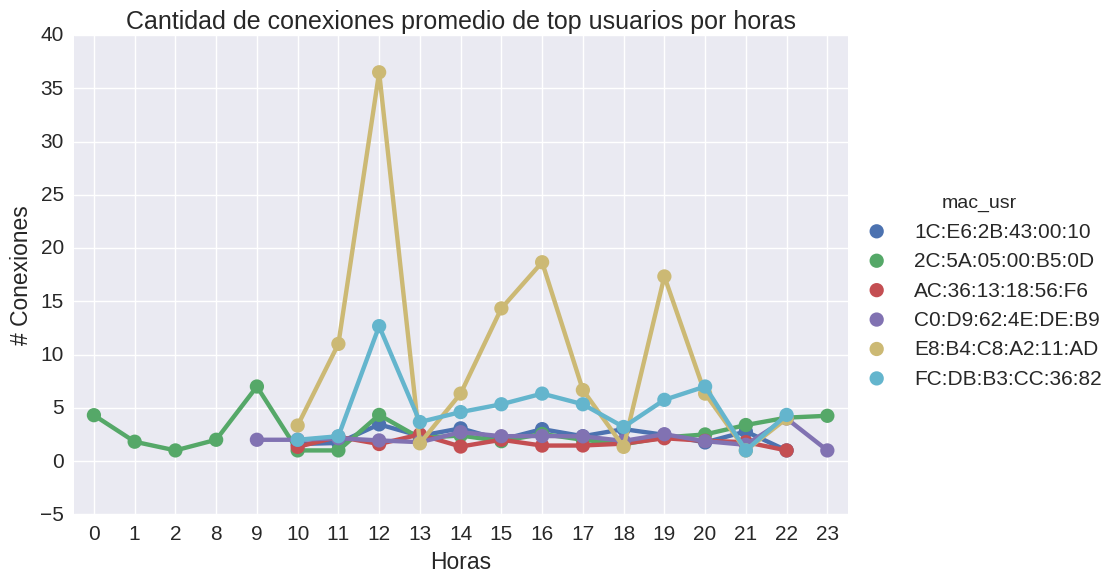

In [46]:
sns.set(font_scale=1.5)
# g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios, size=6, aspect=1.5, hue = "mac_usr")
g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios_samborondon, size=6, aspect=1.5, hue = "mac_usr")
plt.xticks(rotation=0)
plt.xlabel("Horas")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio de top usuarios por horas") 
plt.show()

## Cantidad de conexiones promedio de top usuarios por hora en las Peñas

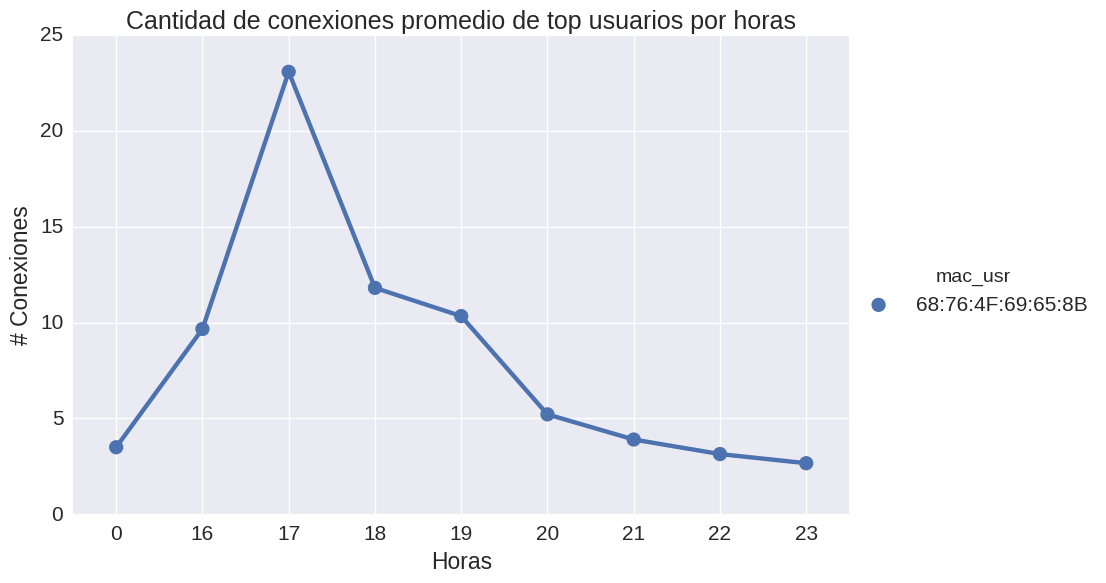

In [56]:
sns.set(font_scale=1.5)
# g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios, size=6, aspect=1.5, hue = "mac_usr")
g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios_penias, size=6, aspect=1.5, hue = "mac_usr")
plt.xticks(rotation=0)
plt.xlabel("Horas")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio de top usuarios por horas") 
plt.show()

## Cantidad de conexiones promedio de top usuarios por hora en Urdesa

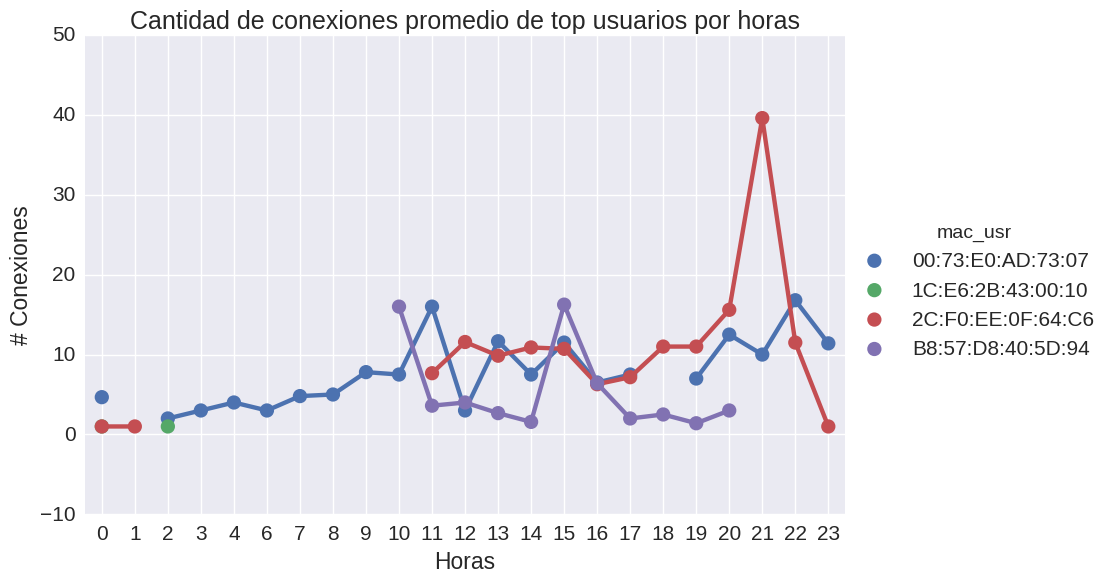

In [57]:
sns.set(font_scale=1.5)
# g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios, size=6, aspect=1.5, hue = "mac_usr")
g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios_urdesa, size=6, aspect=1.5, hue = "mac_usr")
plt.xticks(rotation=0)
plt.xlabel("Horas")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio de top usuarios por horas") 
plt.show()

## Cantidad de conexiones promedio de top usuarios por hora en Mall del Sol

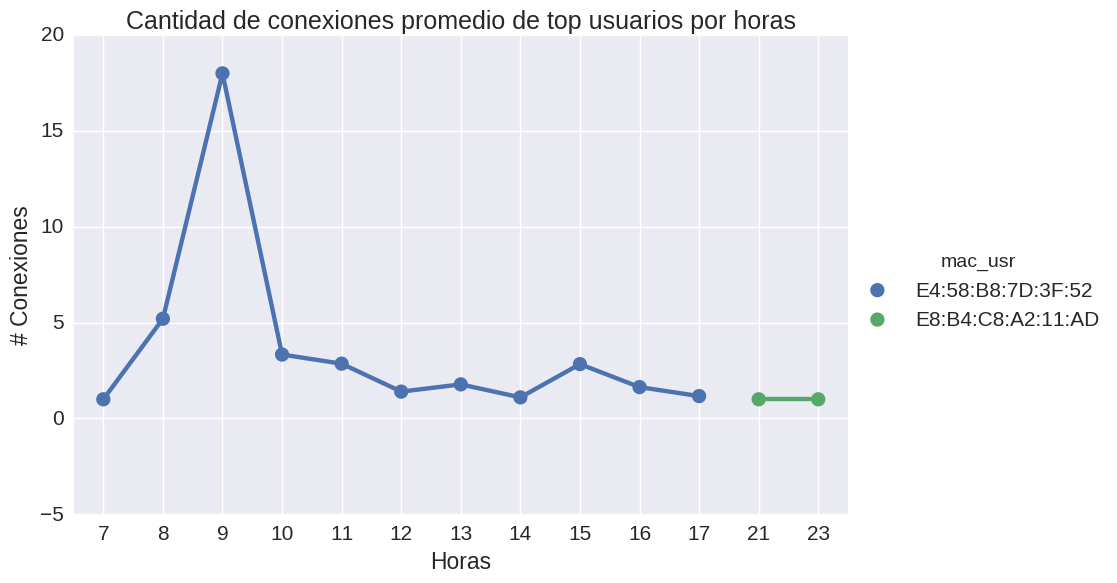

In [58]:
sns.set(font_scale=1.5)
# g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios, size=6, aspect=1.5, hue = "mac_usr")
g = sns.factorplot(x="hora", y="mean_cant_conexiones", data=data_top_usuarios_mallsol, size=6, aspect=1.5, hue = "mac_usr")
plt.xticks(rotation=0)
plt.xlabel("Horas")
plt.ylabel("# Conexiones")
plt.grid(True)
plt.title("Cantidad de conexiones promedio de top usuarios por horas") 
plt.show()

In [95]:
dataAnalisis3B = dataAnalisis3.pivot(index='mac_usr', columns='localizacion_filtrada', values='mean_cant_conexiones')
dataAnalisis3B = dataAnalisis3B.fillna(0).reset_index()
columnas =list(dataAnalisis3B)
columnas.remove("mac_usr")
dataAnalisis3B['total'] = dataAnalisis3B[columnas].sum(axis=1)
columnasNueva = ["total"]
for c in columnas:
    columnasNueva += [c]
    dataAnalisis3B[c] =(dataAnalisis3B[c]*100)/dataAnalisis3B["total"]
dataAnalisis3B = pd.melt(dataAnalisis3B, id_vars=["mac_usr", "total"], var_name='localizacion', value_name='%Frecuencia')
dataAnalisis3B.sort_values("total", ascending = False)
# dataAnalisis3B.sort_values("mac_usr")

,mac_usr,total,localizacion,%Frecuencia
541082,78:C3:E9:30:BB:44,1864.0,CentroConvenciones,100.000000
177861,78:C3:E9:30:BB:44,1864.0,Aeropuerto,0.000000
1267524,78:C3:E9:30:BB:44,1864.0,MallSur,0.000000
1993966,78:C3:E9:30:BB:44,1864.0,Samborondon,0.000000
1630745,78:C3:E9:30:BB:44,1864.0,OTHER,0.000000
904303,78:C3:E9:30:BB:44,1864.0,CityMall,0.000000
1528735,2C:F0:EE:0F:64:C6,981.0,OTHER,100.000000
439072,2C:F0:EE:0F:64:C6,981.0,CentroConvenciones,0.000000
75851,2C:F0:EE:0F:64:C6,981.0,Aeropuerto,0.000000
802293,2C:F0:EE:0F:64:C6,981.0,CityMall,0.000000


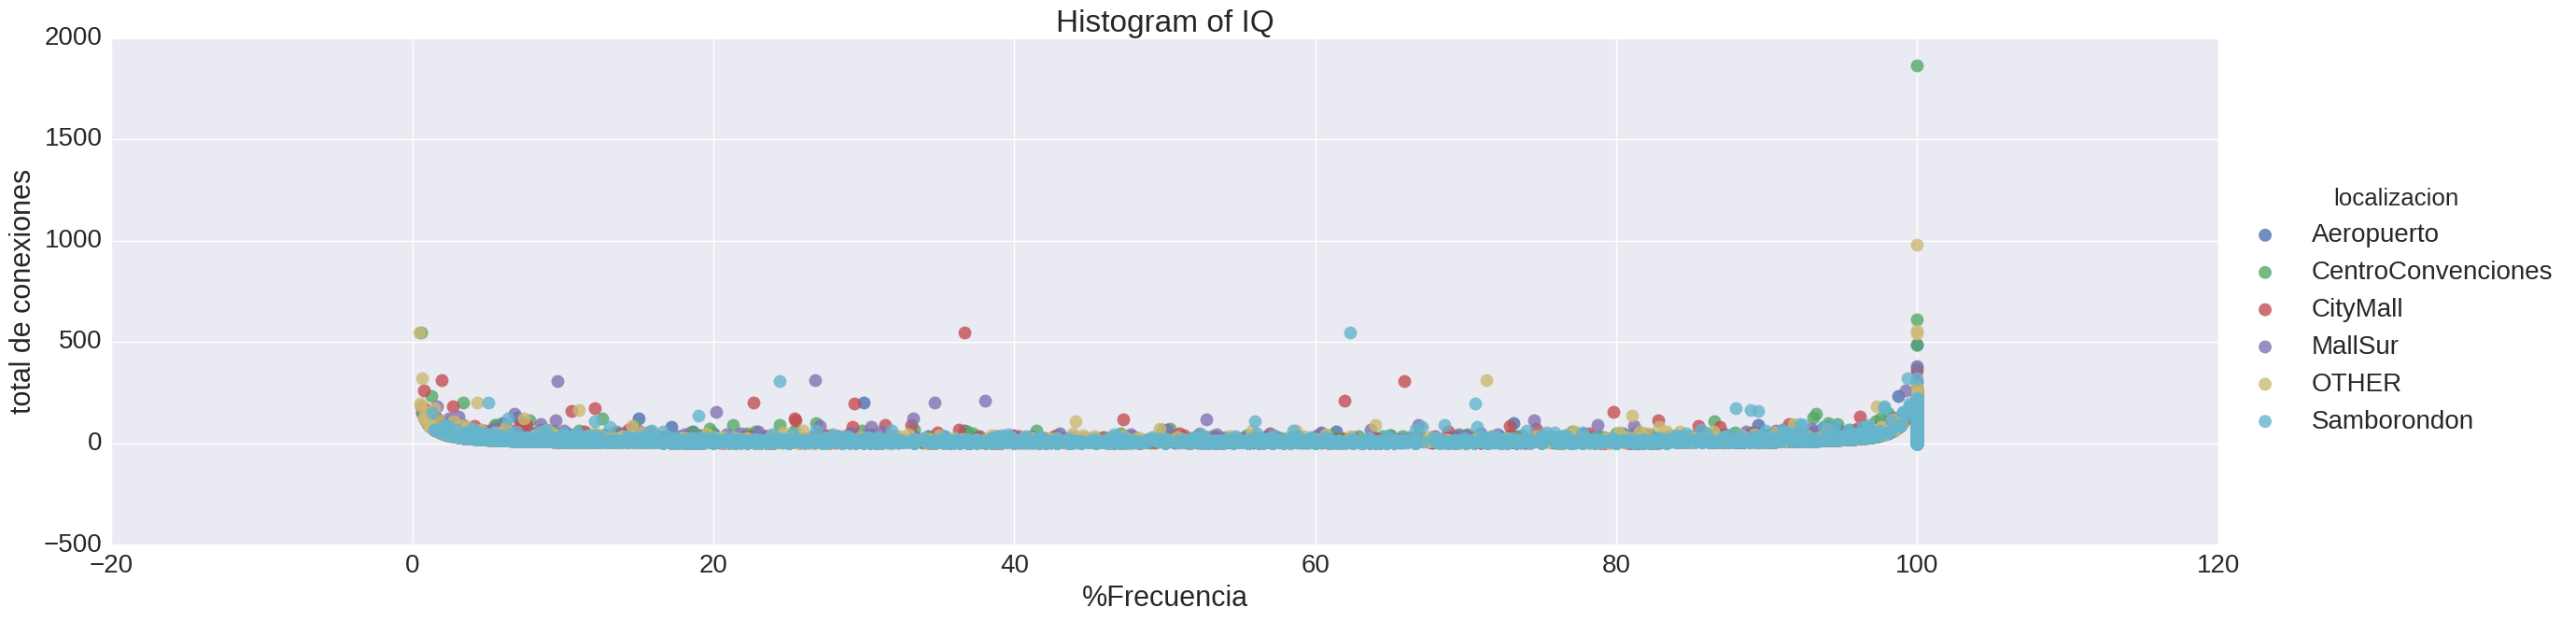

In [98]:
dataAnalisis3BF = dataAnalisis3B[dataAnalisis3B["%Frecuencia"] >0]
sns.lmplot('%Frecuencia', 'total',
           data=dataAnalisis3BF,
           fit_reg=False,  
           scatter_kws={"marker": "D",
                        "s": 100},size=7,aspect=3.5, hue = "localizacion")
plt.title('Histogram of IQ')
plt.xlabel('%Frecuencia')
plt.ylabel('total de conexiones')
plt.show()

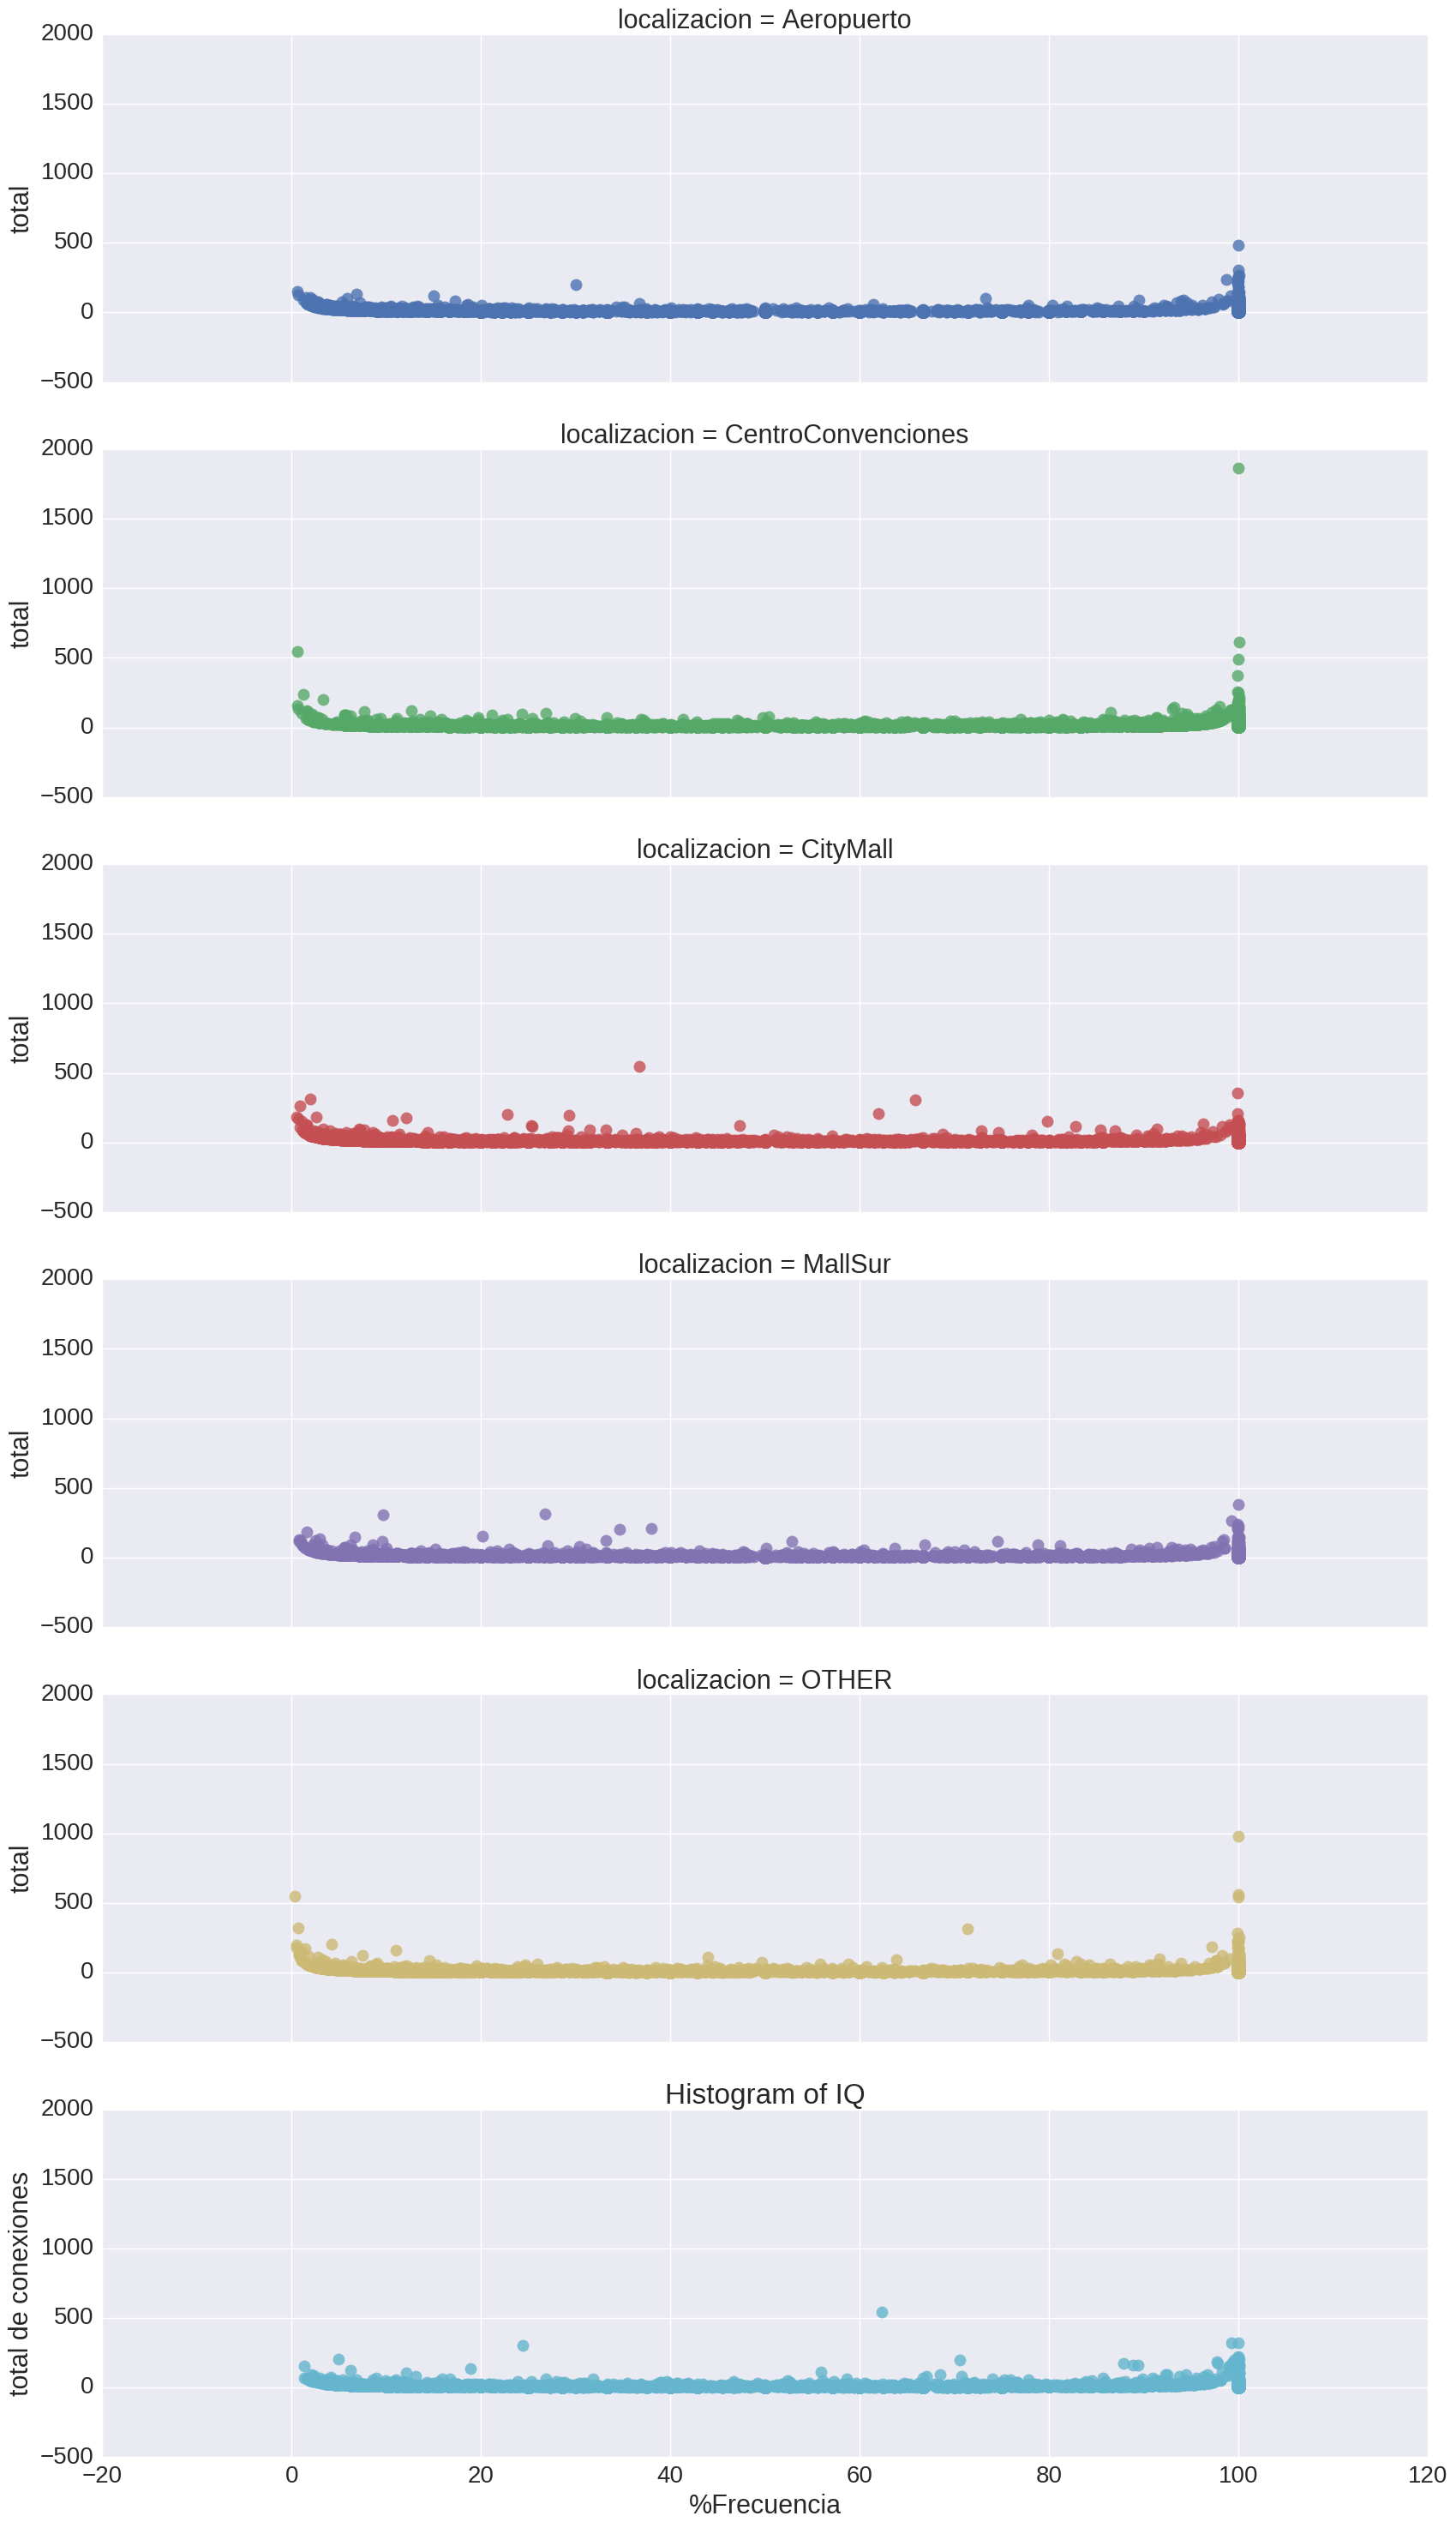

In [103]:
sns.lmplot('%Frecuencia', 'total',
           data=dataAnalisis3BF,
           fit_reg=False,  
           scatter_kws={"marker": "D",
                        "s": 100},size=5, aspect=3.5, hue = "localizacion",row = "localizacion", x_jitter=.1)
plt.title('Histogram of IQ')
plt.xlabel('%Frecuencia')
plt.ylabel('total de conexiones')
plt.show()

In [105]:
import plotly.plotly as py
import plotly
import cufflinks as cf

plotly.tools.set_credentials_file(username='DanielIzquierdo', api_key='s3In15BFpdthgoW1Ow9f')

cf.set_config_file(offline=False, world_readable=True, theme='pearl')

# df = pd.read_csv('http://www.stat.ubc.ca/~jenny/notOcto/STAT545A/examples/gapminder/data/gapminderDataFiveYear.txt', sep='\t')
# df2007 = df[df.year==2007]
# df2007



In [102]:
data2016 = data_completa.copy()
data2016["localizacion_filtrada"] = data2016["localizacion"].apply(lambda x: FiltrarLugares(top5, x))
data2016 = data2016[['localizacion_filtrada','mes']].groupby(['localizacion_filtrada', 'mes']).size().rename('conexiones').reset_index()
connections2016 = data2016.groupby('localizacion_filtrada').mean()
connections = connections2016.reset_index()
connections = connections[['localizacion_filtrada', 'conexiones']]
connections.columns=['CentroComercial','conexiones']
connections

,CentroComercial,conexiones
0,Aeropuerto,101076.200000
1,CentroConvenciones,34139.583333
2,CityMall,38820.166667
3,MallSur,39976.666667
4,OTHER,16875.750000
5,Samborondon,15124.545455


In [103]:
df2016 = pd.merge(connections,expectativa_cc, on='CentroComercial')
df2016 = pd.merge(df2016, aps_cc, on='CentroComercial')
df2016

,CentroComercial,conexiones,poblacion_mensual,#aps
0,Aeropuerto,101076.200000,600000,20
1,CentroConvenciones,34139.583333,55000,33
2,CityMall,38820.166667,1200000,8
3,MallSur,39976.666667,1300000,6
4,Samborondon,15124.545455,750000,11


In [106]:

df2016.iplot(kind='bubble', x='poblacion_mensual', y='#aps', size='conexiones', text='CentroComercial',
             xTitle='Expectativa Mensual del Centro Comercial', yTitle='# de puntos wifi en la zona',
             filename='bubble-chart-wifi-monthly')